<a href="https://colab.research.google.com/github/gaveter/Project_cs/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Project 2019-20
1. Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.
2. For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.
3. Find the lenders that have funded at least twice.
4. For each country, compute how many loans have involved that country as borrowers.
5. For each country, compute the overall amount of money borrowed.
6. Like the previous point, but expressed as a percentage of the overall amount lent.
7. Like the three previous points, but split for each year (with respect to disburse time).
8. For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.
9. For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.
10. Which country has the highest ratio between the difference computed at the previous point and the population?
11. Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?
12. For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

© 2019 GitHub, Inc.

## Install libraries

In [2]:
pip install holidays #libreria necessaria per ritornare informazioni corrette da API Exchange rates

In [3]:
pip install request #libreria necessaria per effettuare richieste HTTP

  Created wheel for request: filename=request-2019.4.13-cp36-none-any.whl size=1677 sha256=28b7da74d2cb1b37a94691a77e485e248854a11a1122ce18b2e5ab258e854492
  Stored in directory: /root/.cache/pip/wheels/30/84/5f/484cfba678967ef58c16fce6890925d5c7172622f20111fbfd
  Created wheel for get: filename=get-2019.4.13-cp36-none-any.whl size=1692 sha256=ab526948d99700720d6ba57fedc6ca148256a906e8b43f28d4e32f42d0bb0b09
  Stored in directory: /root/.cache/pip/wheels/c1/e3/c1/d02c8c58538853e4c9b78cadb74f6d5c5c370b48a69a7271aa
  Created wheel for post: filename=post-2019.4.13-cp36-none-any.whl size=1661 sha256=090dee143c93476a3501d1713283b0d168df2facb7f252b365efcc34f016ca2a
  Stored in directory: /root/.cache/pip/wheels/c3/c3/24/b5c132b537ab380c02d69e6bd4dec1f5db56b5fe19030473d7
  Created wheel for query-string: filename=query_string-2019.4.13-cp36-none-any.whl size=2049 sha256=6dc51a27e9bf820f707af0ae1df47ef073f37b1d112242fb0f337526f318a4f9
  Stored in directory: /root/.cache/pip/wheels/d6/a4/78/01b

## Load libraries

In [0]:
import pandas as pd
from datetime import datetime, timedelta
import re
import numpy as np
import holidays
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import itertools
import requests
import functools
import calendar
from collections import defaultdict

## Task1
- Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.

### Load csv (loans_lenders)

In [0]:
loans_lender = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans_lenders.csv')

_Overview_

In [14]:
loans_lender.dtypes

loan_id     int64
lenders    object
dtype: object

In [9]:
print("Number rows total: "+str(len(loans_lender)))
loans_lender.head()

Number rows total: 1387432


,loan_id,lenders
0,483693,"muc888, sam4326, camaran3922, lachheb1865, reb..."
1,483738,"muc888, nora3555, williammanashi, barbara5610,..."
2,485000,"muc888, terrystl, richardandsusan8352, sherri4..."
3,486087,"muc888, james5068, rudi5955, daniel9859, don92..."
4,534428,"muc888, niki3008, teresa9174, mike4896, david7..."


### Split each lender for each loan_id

In [0]:
loans_lender["lenders"]=loans_lender["lenders"].str.split(', ') #creazione lista per ogni riga
loans_lender_norm=loans_lender.explode('lenders') #trasformazione ogni elemento della lista come una riga

In [0]:
loans_lender_norm=loans_lender_norm.reset_index(drop=True)

### _Result_

In [12]:
loans_lender_norm.head()

,loan_id,lenders
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499


## Task2
- For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.

### Load csv (loans)

In [0]:
loan = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans.csv')

_Overview_

In [45]:
loan.dtypes

loan_id                              int64
loan_name                           object
original_language                   object
description                         object
description_translated              object
funded_amount                      float64
loan_amount                        float64
status                              object
activity_name                       object
sector_name                         object
loan_use                            object
country_code                        object
country_name                        object
town_name                           object
currency_policy                     object
currency_exchange_coverage_rate    float64
currency                            object
partner_id                         float64
posted_time                         object
planned_expiration_time             object
disburse_time                       object
raised_time                         object
lender_term                        float64
num_lenders

In [46]:
print('Number rows total: '+str(len(loan)))
loan.head()

Number rows total: 1419607


,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.1,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,2,1,NaN,female,true,irregular,field_partner
1,657259,Idalia Marizza,Spanish,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",shared,0.1,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,2,1,NaN,female,true,monthly,field_partner
2,658010,Aasia,English,Aasia is a 45-year-old married lady and she ha...,NaN,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,shared,0.1,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,2,1,"#Woman Owned Biz, #Supporting Family, user_fav...",female,true,monthly,field_partner
3,659347,Gulmira,Russian,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,625.0,625.0,funded,Farming,Agriculture,"to buy cucumber and tomato seeds, as well as f...",KG,Kyrgyzstan,"Aravan village, Osh region",shared,0.1,KGS,171.0,2014-01-20 09:59:48.000 +0000,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,2014-01-22 05:29:28.000 +0000,14.0,21,2,1,user_favorite,female,true,monthly,field_partner
4,656933,Ricky\t,English,Ricky is a farmer who currently cultivates his...,NaN,425.0,425.0,funded,Farming,Agriculture,to buy organic fertilizer and agrochemical pr...,PH,Philippines,"Baleleng, Sto. Thomas, Isabela",shared,0.1,PHP,123.0,2014-01-14 05:46:21.000 +0000,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,2014-01-14 17:29:27.000 +0000,7.0,15,2,1,"#Animals, #Eco-friendly, #Sustainable Ag",male,true,bullet,field_partner


### Check missing values

In [0]:
missing_loan_expiration = pd.isnull(loan[['planned_expiration_time']])
missing_loan_disburse = pd.isnull(loan[['disburse_time']])

In [0]:
missing_loan_index_e = missing_loan_expiration[missing_loan_expiration['planned_expiration_time']==True].index
missing_loan_index_d = missing_loan_disburse[missing_loan_disburse['disburse_time']==True].index

In [49]:
print('Number rows which have nan values planned_expiration_time: '+str(len(missing_loan_index_e)))
print('Number rows which have nan values disburse_time: '+str(len(missing_loan_index_d)))

Number rows which have nan values planned_expiration_time: 371834
Number rows which have nan values disburse_time: 2813


In [0]:
missing_loan_index = missing_loan_index_e.union(missing_loan_index_d) #union indici nan disburse e nan expiration

In [51]:
loan.loc[missing_loan_index][['planned_expiration_time','disburse_time']]

,planned_expiration_time,disburse_time
64,NaN,2010-11-18 08:00:00.000 +0000
65,NaN,2010-11-25 08:00:00.000 +0000
66,NaN,2010-11-25 08:00:00.000 +0000
67,NaN,2010-11-16 08:00:00.000 +0000
69,NaN,2010-11-10 08:00:00.000 +0000
...,...,...
1419523,NaN,2005-04-14 05:27:55.000 +0000
1419524,2017-02-09 23:07:54.000 +0000,NaN
1419525,2015-09-21 08:06:19.000 +0000,NaN
1419538,2017-02-25 20:21:21.000 +0000,NaN


### Conversion attributes planned_expiration_time, disburse_time to _Datetime_

In [0]:
loan['planned_expiration_time'] = pd.to_datetime(loan.loc[:,'planned_expiration_time'])
loan['disburse_time'] = pd.to_datetime(loan.loc[:,'disburse_time'])

In [88]:
missing = loan.loc[missing_loan_index]
print('Number rows missing: '+str(len(missing)))
print('Ratio missing: '+str(len(missing) / len(loan)))

Number rows missing: 374645
Ratio missing: 0.26390754624343216


### Compute difference between planned_expiration_time and disburse_time

In [0]:
loan['duration'] = loan['planned_expiration_time']- loan['disburse_time'] #si ottiene oggetto timedelta

In [0]:
loan['duration'] = loan.apply(lambda x: x['duration'].days,axis=1)

### _Result_

In [118]:
loan.head()[['planned_expiration_time','disburse_time','duration']]

,planned_expiration_time,disburse_time,duration
0,2014-02-14 03:30:06+00:00,2013-12-22 08:00:00+00:00,53.0
1,2014-03-26 22:25:07+00:00,2013-12-20 08:00:00+00:00,96.0
2,2014-02-15 21:10:05+00:00,2014-01-09 08:00:00+00:00,37.0
3,2014-02-21 03:10:02+00:00,2014-01-17 08:00:00+00:00,34.0
4,2014-02-13 06:10:02+00:00,2013-12-17 08:00:00+00:00,57.0


## Task 3
- Find the lenders that have funded at least twice

In [0]:
numberfunded_lenders = loans_lender_norm.groupby('lenders')['loan_id'].count()

### Apply constraint after group by 

In [0]:
numberfunded_lenders = pd.DataFrame(numberfunded_lenders).reset_index(drop=False)
numberfunded_lenders.columns = ['lenders','count']

numberfunded_lenders = numberfunded_lenders[numberfunded_lenders['count']>=2]

### _Result_

In [137]:
numberfunded_lenders.head()

,lenders,count
0,000,40
1,00000,39
2,0002,70
4,0101craign0101,71
5,0132575,4


_Result (ordered)_

In [138]:
numberfunded_lenders.sort_values(by='count',ascending=False)

,lenders,count
462833,gooddogg1,177645
1324411,trolltech4460,150762
462243,gmct,128159
1008585,nms,104314
1290437,themissionbeltco,81434
...,...,...
617611,joel7934,2
1118045,robert59171360,2
617600,joel7821,2
1118054,robert59284318,2


## Task 4
- For each country, compute how many loans have involved that country as borrowers.

### Check missing values

In [146]:
missing = pd.isnull(loan[['country_name']])
missing[missing['country_name']==True]

,country_name


In [0]:
country_numberLoan = loan.groupby('country_name')['loan_id'].count()
country_numberLoan = pd.DataFrame(country_numberLoan).reset_index(drop=False)
country_numberLoan.columns=['country','count']

### _Result_

In [152]:
country_numberLoan.head()

,country,count
0,Afghanistan,2337
1,Albania,3075
2,Armenia,13952
3,Azerbaijan,10172
4,Belize,218


_Result ordered_

In [0]:
country_numberLoan.sort_values(by='count',ascending=False).head()

,country,count
66,Philippines,285257
40,Kenya,143394
65,Peru,85983
14,Cambodia,79682
27,El Salvador,63917


## Task 5
- For each country, compute the overall amount of money borrowed.

N.B. For this task I've decided to convert 'funded_amount' to USD for each loan due to need to sum all amount money for each country

In [0]:
loan_simplified = loan_noZeroLenders[['loan_id','country_name','disburse_time','planned_expiration_time',
                                      'num_lenders_total','funded_amount','loan_amount','currency']]

### Functions needed to check if date represent week-end or not

In [0]:
def check_weekend(date_time):
  date = date_time.date() #conversione data 
  day_week = date.weekday()
  delta=0
  if day_week >=5:
    date_r = date - pd.tseries.offsets.BDay(1)
  else:
    date_r = date
  return date_r

In [0]:
loan_simplified['disburse_time_API'] = loan_simplified.apply(lambda x: check_weekend(x['disburse_time']),axis=1)
loan_simplified['disburse_time_API']=loan_simplified['disburse_time_API'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Check missing values

In [0]:
missing = pd.isnull(loan_simplified[['currency']])
missing[missing['currency']==True]

,currency


### Call API to get all currency available

In [0]:
date = loan_simplified['disburse_time_API'][0]
request_link = 'https://api.exchangeratesapi.io/history?start_at='+date+"&end_at="+date+"&base=USD"

request_API = requests.get(request_link) #richiesta API
dict_request = request_API.json()
dict_currency_legend = dict_request['rates'][date]

In [0]:
global currency_list_legend
currency_list_legend = dict_currency_legend.keys() #lista currency convertibile

### Functions needed to check if current currency is convertible or not

In [0]:
def check_currency(currency): #controlla se valuta corrente è 'convertibile' (esiste tasso di cambio)
  if currency not in currency_list_legend:
    conv = False
  else:
    conv = True
  return conv

In [0]:
currency_included = pd.DataFrame(loan_simplified['currency'].unique())
currency_included.columns=['currency']
currency_included = currency_included[currency_included['currency']!='USD']
currency_included['conversion'] = currency_included.apply(lambda x: check_currency(x['currency']),axis=1)

### Left join between loans and currency convertible

In [0]:
loan_simplified = pd.merge(loan_simplified,currency_included,how='left',on='currency')

In [0]:
firstBlock = loan_simplified[loan_simplified['conversion']==True] #parte df dove le valute possone essere convertite
firstBlock_index = firstBlock.index

In [0]:
secondBlock = loan_simplified.drop(firstBlock_index,axis=0)

In [0]:
secondBlock['funded_amount_conversion_USD'] = secondBlock['funded_amount']
secondBlock['loan_amount_conversion_USD'] = secondBlock['loan_amount']

### Functions needed to get last business day if date was holiday

In [0]:
def get_last_business_day_before_holidays(date,holidays): #va a ritroso fino a quando non trova un giorno della settimana che non sia festività
  while date in holidays:
    date = date - pd.tseries.offsets.BDay(1)
  return date
    

def check_holidays(date):
  date_datetime = datetime.strptime(date,'%Y-%m-%d')
  holiday_EU = holidays.EuropeanCentralBank(years = date_datetime.year)
  if date in holiday_EU:
    date_r=get_last_business_day_before_holidays(date_datetime,holiday_EU)
    date_r=date_r.strftime('%Y-%m-%d')
  else:
    date_r=date
  return date_r

In [0]:
firstBlock['disburse_time_API']= firstBlock.apply(lambda x: check_holidays(x['disburse_time_API']),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Functions needed to get for each date currency that have to converted

In [0]:
def create_dictionary_currency(list_dict): #funzione che crea dizionario da una lista
  dates_dict = defaultdict(list)
  for key, info in list_dict:
    #print(key, info)
    dates_dict[key].append(info)
  return dates_dict
  

def get_pair(currency, date):
  pair = (date,currency)
  return pair

def fill_list_map1(currency, dates):
  dates_list = [item for sublist in dates for item in sublist] #date loan di ogni valuta
  info_rate = list(map (functools.partial(get_pair, currency), dates_list)) #funzione viene passata la stessa valuta
  return info_rate

def create_list_currency_map1(df, currency_list):
  dict_currency_list=list()
  date_loan_list = list()
  for i in currency_list:
    loan_currency = df[df['currency']==i][['disburse_time_API','currency']]
    date_loan_currency = set(loan_currency['disburse_time_API'].tolist()) #elimino date duplicate
    date_loan_list.append([date_loan_currency])

  
  dict_currency_list = list(map(lambda x,y: fill_list_map1(x,y), currency_list, date_loan_list))
  return dict_currency_list

In [0]:
currency = firstBlock['currency'].unique()
dict_currency_list = create_list_currency_map1(firstBlock, currency)

In [0]:
flat_dict_currency_list = [item for sublist in dict_currency_list for item in sublist]
dict_date_currency = create_dictionary_currency(flat_dict_currency_list) #creo dizionario

### Functions needed to get for each currency its rate for the current date

In [0]:
def extract_rate(dict_API, date,currency):
  if currency in dict_API.keys():
    rate = dict_API[currency]
  else:
    rate = np.NaN
  return (currency,rate)

def call_API(dict_date,date):
  request = 'https://api.exchangeratesapi.io/history?start_at='+date+'&end_at='+date+'&base=USD'
  request_API = requests.get(request)
  dict_API = request_API.json()
  dict_API = dict_API['rates'][date]
  rate_currency = list(map (functools.partial(extract_rate, dict_API, date), dict_date[date]))
  #print(rate_currency)
  return (date,rate_currency)


def get_list_currency_rate(dates_list,dict_date):
  rate_list = list(map (functools.partial(call_API, dict_date), dates_list))
  return rate_list

In [0]:
dates_request = dict_date_currency.keys() #lista date da usare per chiamare API
dates_request = list(dates_request)

In [0]:
inizio = datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
dict_currency_list = get_list_currency_rate(dates_request, dict_date_currency)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff

Inizio: 17:31:12
Fine: 17:35:57


datetime.timedelta(0, 284, 552244)

In [0]:
dict_currency = create_dictionary_currency(dict_currency_list) #dizionario che contiene tutti i tassi di cambio

### Function needed to flat list currency for each date

In [0]:
def flat_list(list):
  return [item for sublist in list for item in sublist]

In [0]:
date_currency = pd.DataFrame(dict_currency.items()) #.items ritorna lista tuple coppia key value
date_currency.columns = ['date','currency']

In [0]:
date_currency['currency']=date_currency.apply(lambda x: flat_list(x['currency']),axis=1)
date_currency = date_currency.explode('currency').reset_index()

In [0]:
date_currency['curr']=date_currency.apply(lambda x: x['currency'][0],axis=1)
date_currency['rate']=date_currency.apply(lambda x: x['currency'][1],axis=1)

date_currency.drop(columns=['index','currency'],inplace=True)

In [0]:
date_currencyNaN_index = date_currency[date_currency.isna().any(axis=1)].index
date_currencyNan = date_currency.loc[date_currencyNaN_index]

In [0]:
date_currency.drop(index=date_currencyNaN_index,inplace=True)

### Functions needed to fix problem with particular pair date, currency

In [0]:
def get_valid_day(date,currency):
  if currency=='ILS': #ILS non presenta info antecendenti al 2011, MXN dal 2008
    date = datetime.strptime('2011-01-03','%Y-%m-%d')
  else:
    date = datetime.strptime('2008-01-02','%Y-%m-%d')
  return date

def get_info_from_API(date): #chiamata API
  date = date.strftime('%Y-%m-%d')
  request = 'https://api.exchangeratesapi.io/history?start_at='+date+'&end_at='+date+'&base=USD'
  request_API = requests.get(request)
  dict_API = request_API.json()
  dict_API = dict_API['rates'][date]
  return dict_API

def get_last_date_currency(currency,date):
  date = datetime.strptime(date,'%Y-%m-%d')
  date = get_valid_day(date,currency)
  dict_result = get_info_from_API(date)
  while currency not in dict_result.keys():
    date = get_valid_day(date)
    dict_result = get_info_from_API(date)
  return dict_result[currency]

In [0]:
date_currencyNan['rate'] = date_currencyNan.apply(lambda x: get_last_date_currency(x['curr'],x['date']),axis=1)
date_currency = pd.concat([date_currency,date_currencyNan],axis=0)

### Inner join between rows which contains currency convertible and DataFrame which contains for each pair date, currency the rate

In [0]:
firstBlock = pd.merge(firstBlock,date_currency,how='inner',left_on=['disburse_time_API','currency'],right_on = ['date','curr'])

In [0]:
firstBlock.drop(columns=['date','curr'],inplace=True)

### Compute conversion

In [0]:
firstBlock['funded_amount_conversion_USD']=round(firstBlock['funded_amount']/firstBlock['rate'],2)
firstBlock['loan_amount_conversion_USD']=round(firstBlock['loan_amount']/firstBlock['rate'],2)

In [0]:
loan_simplified_USD = pd.concat([firstBlock,secondBlock],axis=0,sort=False)

In [0]:
country_amount_loan = pd.DataFrame(loan_simplified_USD.groupby('country_name')['loan_amount_conversion_USD'].sum()).reset_index()
country_amount_loan.columns = ['country','overall_USD']

### _Result_

In [0]:
country_amount_loan.head()

,country,overall_USD
0,Afghanistan,1967100.00
1,Albania,4311789.39
2,Armenia,22940550.00
3,Azerbaijan,14782600.00
4,Belize,150175.00


_Result (ordered)_

In [0]:
country_amount_loan.sort_values(by='overall_USD',ascending=False).head()

,country,overall_USD
65,Peru,79419775.0
40,Kenya,66558850.0
64,Paraguay,53958650.0
14,Cambodia,51596900.0
7,Bolivia,44175425.0


## Task 6
- Like the previous point, but expressed as a percentage of the overall amount lent.

In [0]:
country_amount_loan_perc=pd.DataFrame(country_amount_loan)
country_amount_loan_perc.columns = ['country','borrowed']

### Compute ratio between total country and overall amount

In [0]:
total=country_amount_loan_perc['borrowed'].sum()
country_amount_loan_perc['percentage']=round(country_amount_loan_perc['borrowed']/total*100,2)

### _Result_

In [0]:
country_amount_loan_perc.head()

,country,borrowed,percentage
0,Afghanistan,1967100.00,0.19
1,Albania,4311789.39,0.41
2,Armenia,22940550.00,2.21
3,Azerbaijan,14782600.00,1.42
4,Belize,150175.00,0.01


_Result (ordered)_

In [0]:
country_amount_loan_perc.sort_values(by='percentage',ascending=False).head()

,country,borrowed,percentage
65,Peru,79419775.0,7.64
40,Kenya,66558850.0,6.40
64,Paraguay,53958650.0,5.19
14,Cambodia,51596900.0,4.96
7,Bolivia,44175425.0,4.25


## Task 7
- Like the three previous points, but split for each year (with respect to disburse time).

In [0]:
loanYear = loan_simplified_USD

### Check missing values

In [0]:
missing = loanYear[loanYear['disburse_time'].isnull()]
missing

,loan_id,country_name,disburse_time,planned_expiration_time,num_lenders_total,funded_amount,loan_amount,currency,disburse_time_API,conversion,rate,funded_amount_conversion_USD,loan_amount_conversion_USD
1048274,1379508,United States,NaT,2017-12-06 16:41:36,2,125.0,1000.0,USD,NaT,NaN,NaN,125.0,1000.0
1048304,1135319,United States,NaT,2016-09-02 20:27:46,2,50.0,500.0,USD,NaT,NaN,NaN,50.0,500.0
1048484,1393319,United States,NaT,2017-11-02 22:48:50,13,650.0,1000.0,USD,NaT,NaN,NaN,650.0,1000.0
1048515,1429461,United States,NaT,2018-01-13 20:53:52,86,2550.0,10000.0,USD,NaT,NaN,NaN,2550.0,10000.0
1048552,1089628,United States,NaT,2015-08-15 20:40:37,3,75.0,1500.0,USD,NaT,NaN,NaN,75.0,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417033,1082442,United States,NaT,2014-10-14 16:05:01,37,510.0,3000.0,USD,NaT,NaN,NaN,510.0,3000.0
1417035,1227124,United States,NaT,2017-02-09 23:07:54,9,800.0,10000.0,USD,NaT,NaN,NaN,800.0,10000.0
1417036,1089430,Kenya,NaT,2015-09-21 08:06:19,3,125.0,225.0,KES,NaT,False,NaN,125.0,225.0
1417037,1235452,United States,NaT,2017-02-25 20:21:21,3,600.0,3000.0,USD,NaT,NaN,NaN,600.0,3000.0


In [0]:
loanYear = loanYear[loanYear['disburse_time'].isnull()==False] #non considero tuple che non hanno valore in 'disburse_time'

### Get Year from date 'disburse' for each loan

In [0]:
loanYear['year'] = loanYear.apply(lambda x: x['disburse_time'].year,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
country_amount_year=loanYear.groupby(['country_name','year'])['loan_amount_conversion_USD'].sum()
country_amount_year = pd.DataFrame(country_amount_year)

### _Result_

In [0]:
country_amount_year.head()

loan_amount_conversion_USD
country_name year                            
Afghanistan  2007                    194975.0
             2008                    365375.0
             2009                    584275.0
             2010                    563350.0
             2011                    245125.0

## Task 8
- For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.

In [0]:
number_loans_lender_norm=loans_lender_norm.groupby('loan_id')['lenders'].count()
number_loans_lender_norm=pd.DataFrame(number_loans_lender_norm).reset_index(level=0)
number_loans_lender_norm

,loan_id,lenders
0,84,3
1,85,2
2,86,3
3,88,3
4,89,4
...,...,...
1387427,1444051,1
1387428,1444053,1
1387429,1444058,1
1387430,1444063,1


### Get number lenders for each loan

In [0]:
loans_lender_amount = pd.merge(loan_simplified_USD,number_loans_lender_norm,how="inner",on="loan_id")
loans_lender_amount= loans_lender_amount[['loan_id','num_lenders_total','lenders','funded_amount_conversion_USD']]

In [0]:
correct = loans_lender_amount[loans_lender_amount['num_lenders_total']==loans_lender_amount['lenders']]
wrong = loans_lender_amount[loans_lender_amount['num_lenders_total']!=loans_lender_amount['lenders']]

In [0]:
#plot barchart da fare
print("Info giuste: "+str(len(correct)/len(loans_lender_amount)))
print("Info sbagliate: "+str(len(wrong)/len(loans_lender_amount)))

Info giuste: 0.1917209397532701
Info sbagliate: 0.8082790602467299


### Fixed count lenders for each loan

In [0]:
loans_lender_amount.drop(columns='num_lenders_total',inplace=True)

In [0]:
loans_lender_amount.head()

,loan_id,lenders,funded_amount_conversion_USD
0,657307,3,2.81
1,654523,11,8.98
2,657419,11,7.86
3,652191,8,5.61
4,657423,9,10.10


### Compute contribution lenders for each loan

In [0]:
loans_lender_amount['amount']=round(loans_lender_amount['funded_amount_conversion_USD']/loans_lender_amount['lenders'],2)

In [0]:
loans_lender_amount.head()

,loan_id,lenders,funded_amount_conversion_USD,amount
0,657307,3,2.81,0.94
1,654523,11,8.98,0.82
2,657419,11,7.86,0.71
3,652191,8,5.61,0.70
4,657423,9,10.10,1.12


In [0]:
amount_loan_lender = pd.merge(loans_lender_norm,loans_lender_amount,how="inner",on='loan_id')
amount_loan_lender.drop(columns=['funded_amount_conversion_USD','lenders_y'],inplace=True)
amount_loan_lender.columns=['loan_id','lenders','amount'] 

In [0]:
amount_lender = amount_loan_lender.groupby('lenders')['amount'].sum()
amount_lender = pd.DataFrame(amount_lender).reset_index(level=0)

In [0]:
amount_lender['amountFormat']=amount_lender.apply(lambda x: format(x['amount'],'f'),axis=1)

### _Result_

In [0]:
amount_lender.head()

,lenders,amount,amountFormat
0,000,1449.05,1449.050000
1,00000,1284.30,1284.300000
2,0002,1603.66,1603.660000
3,00mike00,52.63,52.630000
4,0101craign0101,2530.51,2530.510000


_Result (ordered)_

In [0]:
amount_lender.sort_values(by='amount',ascending=False).head()

,lenders,amount,amountFormat
462833,gooddogg1,6083410.32,6083410.320000
1324411,trolltech4460,4951580.17,4951580.170000
1008585,nms,4005556.35,4005556.350000
462243,gmct,3529476.99,3529476.990000
158450,bob4739,3273832.60,3273832.600000


## Task 9
- For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

### Load csv
1. lenders
2. country_stats

In [0]:
lenders = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/lenders.csv')

_Overview_

In [0]:
lenders.dtypes

permanent_name        object
display_name          object
city                  object
state                 object
country_code          object
member_since           int64
occupation            object
loan_because          object
loan_purchase_num    float64
invited_by            object
num_invited            int64
dtype: object

In [0]:
print('Number rows total: '+str(len(lenders)))
lenders.head()

Number rows total: 2349174


,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited
0,qian3013,Qian,NaN,NaN,NaN,1461300457,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,1461300634,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,1461301091,NaN,NaN,5.0,Peter Tan,0
4,nguyen6962,Nguyen,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,0


In [0]:
country_info=pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/country_stats.csv')

_Overview_

In [0]:
country_info.dtypes

country_name                      object
country_code                      object
country_code3                     object
continent                         object
region                            object
population                         int64
population_below_poverty_line    float64
hdi                              float64
life_expectancy                  float64
expected_years_of_schooling      float64
mean_years_of_schooling          float64
gni                              float64
kiva_country_name                 object
dtype: object

In [0]:
print('Number rows total: '+str(len(country_info)))
country_info.head()

Number rows total: 174


,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh


In [0]:
country_info = country_info[['country_name','country_code','population','population_below_poverty_line']] #population is included because it needed for the 10 task

In [0]:
lenders = lenders[['permanent_name','country_code']]

### Check missing values

In [0]:
country_info[country_info['country_code'].isna()]

,country_name,country_code,population,population_below_poverty_line
115,Namibia,NaN,2533794,28.7


In [0]:
unknown_lenders = lenders[lenders['country_code'].isna()]
tot = len(lenders)

In [0]:
print("Country lenders not known: "+str(len(unknown_lenders)/tot))

Country lenders not known: 0.620913989342637


In [0]:
lenders.drop(index=unknown_lenders.index,inplace=True)

### Inner join between lenders and info country (useful to get country name)

In [0]:
lenders_country = pd.merge(lenders,country_info,how='inner',on='country_code')
lenders_country.drop(columns='country_code',inplace=True)

In [0]:
lenders_country.drop(columns=['population','population_below_poverty_line'],inplace=True)
lenders_country.columns=['lenders','country_name']

In [0]:
lenders_country_dist = lenders_country.groupby('country_name')['lenders'].count()
lenders_country_dist = pd.DataFrame(lenders_country_dist).reset_index(level=0)

### Compute distribution country lenders known

In [0]:
number_lenders = lenders_country_dist['lenders'].sum()
lenders_country_dist['distribution'] = lenders_country_dist['lenders'] / number_lenders

In [0]:
lenders_country_dist= lenders_country_dist.sort_values(by='lenders',ascending=False)
lenders_country_dist['distribution_100'] = round(lenders_country_dist['distribution'] * 100,2)

### Barchart distribution country lenders known

([], <a list of 0 Text xticklabel objects>)

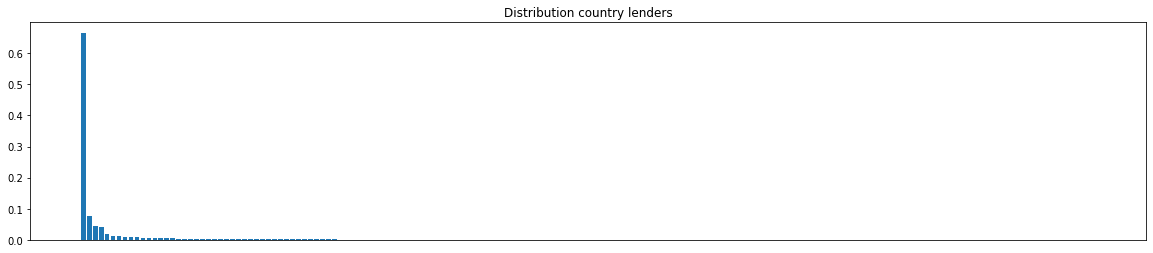

In [0]:
fig = plt.figure(figsize=(20,4))
plt.bar(lenders_country_dist['country_name'],lenders_country_dist['distribution'])
plt.title('Distribution country lenders')
plt.xticks(ticks=[])

Text(0, 0.5, 'percentage(%)')

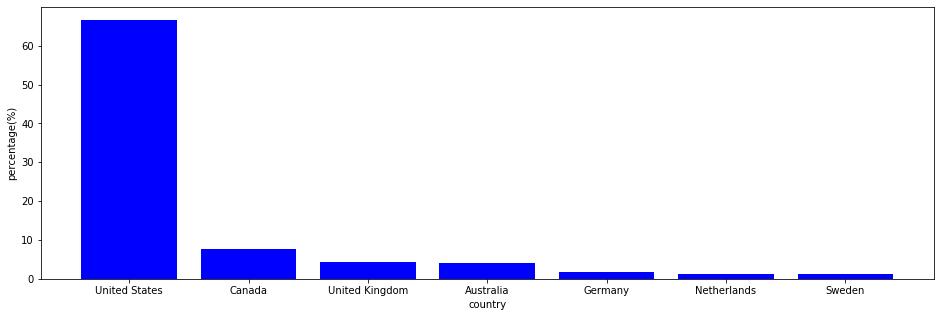

In [0]:
dist_focus = lenders_country_dist[lenders_country_dist['distribution_100']>1]
fig = plt.figure(figsize=(16,5))
plt.bar(dist_focus['country_name'],dist_focus['distribution_100'],color='blue')
plt.xlabel('country')
plt.ylabel('percentage(%)')

In [0]:
lenders_country_dist['numberRecord']=round(lenders_country_dist['distribution']*len(unknown_lenders),0)
lenders_country_dist['numberRecord'] = lenders_country_dist.apply(lambda x: int(x['numberRecord']),axis=1)
lenders_country_dist

,country_name,lenders,distribution,distribution_100,numberRecord
162,United States,591612,0.666188,66.62,971725
26,Canada,67970,0.076538,7.65,111641
161,United Kingdom,38380,0.043218,4.32,63039
6,Australia,37103,0.041780,4.18,60942
53,Germany,16007,0.018025,1.80,26292
...,...,...,...,...,...
157,Turkmenistan,4,0.000005,0.00,7
44,Eritrea,4,0.000005,0.00,7
96,Mauritania,4,0.000005,0.00,7
30,Comoros,1,0.000001,0.00,2


In [0]:
lenders_country_dist['countryLender']=lenders_country_dist.apply(lambda x: [x['country_name']]*x['numberRecord'],axis=1)

In [0]:
country_lender_unknown = pd.Series.to_list(lenders_country_dist['countryLender']) #concateno tutte le liste

In [0]:
country_lender_unknown = list(itertools.chain(*country_lender_unknown)) #flat list
country_lender_unknown = country_lender_unknown[:-2]

### Replace NAN according distribution computed before

In [0]:
unknown_lenders['country_name']=country_lender_unknown
unknown_lenders.drop(columns='country_code',inplace=True)
unknown_lenders.columns=['lenders','country_name']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
dist_unknown_lenders = pd.DataFrame(unknown_lenders.groupby('country_name')['lenders'].count()).reset_index()
total = len(unknown_lenders)

In [0]:
dist_unknown_lenders['distribution'] = dist_unknown_lenders['lenders']/total
dist_unknown_lenders['distribution_100'] = round(dist_unknown_lenders['distribution']*100,2)

In [0]:
dist_unknown_lenders = dist_unknown_lenders.sort_values(by='distribution',ascending=False)
dist_unknown_lenders_focus=dist_unknown_lenders[dist_unknown_lenders['distribution_100']>1]

In [0]:
dist_unknown_lenders_focus.drop(columns='distribution',inplace=True)
dist_unknown_lenders_focus.columns=['country_name','lenders_unknown','distribution_unknown']
dist_focus.drop(columns=['distribution'],inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
compare_dist = pd.merge(dist_focus,dist_unknown_lenders_focus,how='inner',on='country_name')
compare_dist.drop(columns=['lenders','lenders_unknown'],inplace=True)

### Barchart compare distribution

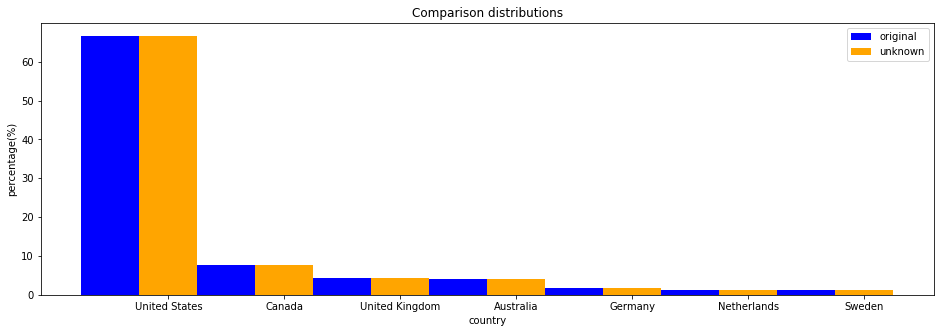

In [0]:
country = compare_dist['country_name']
x = np.arange(len(compare_dist))
fig = plt.figure(figsize=(16,5))
bar_width = 0.5

plt.bar(x,compare_dist['distribution_100'],width=bar_width,color='blue',label='original')
plt.bar(x+bar_width,compare_dist['distribution_unknown'],width=bar_width,color='orange',label='unknown')
plt.title('Comparison distributions')
plt.xticks(x+bar_width,country)
plt.xlabel('country')
plt.ylabel('percentage(%)')
plt.legend()

In [0]:
lenders_country = pd.concat([lenders_country,unknown_lenders],axis=0)

### Get amount for each lender and his country

In [0]:
amount_lender_country = pd.merge(amount_lender,lenders_country,how='inner',on='lenders')

In [0]:
country_amount_lent = amount_lender_country.groupby('country_name')['amount'].sum()
country_amount_lent = pd.DataFrame(country_amount_lent).reset_index(level=0)

In [0]:
country_amount_lent.columns=['country','lent']

### Inner join between amount country borrowed and amount country lent

In [0]:
country_difference = pd.merge(country_amount_loan_perc,country_amount_lent,how='inner',on='country')
country_difference.drop(columns='percentage',inplace=True)

In [0]:
country_difference['difference'] = country_difference['lent'] - country_difference['borrowed']

### _Result_

In [0]:
country_difference.head()

,country,borrowed,lent,difference
0,Afghanistan,1967100.00,144623.21,-1822476.79
1,Albania,4311789.39,48511.26,-4263278.13
2,Armenia,22940550.00,137401.62,-22803148.38
3,Azerbaijan,14782600.00,33419.68,-14749180.32
4,Belize,150175.00,36837.14,-113337.86


_Result (ordered)_

In [0]:
country_difference.sort_values(by='difference',ascending=True).head()

,country,borrowed,lent,difference
58,Peru,79419775.0,170554.45,-79249220.55
36,Kenya,66558850.0,593217.09,-65965632.91
57,Paraguay,53958650.0,63361.73,-53895288.27
14,Cambodia,51596900.0,184880.85,-51412019.15
7,Bolivia,44175425.0,72408.81,-44103016.19


## Task 10
- Which country has the highest ratio between the difference computed at the previous point and the population?

In [0]:
country_difference = pd.merge(country_difference,country_info,how='inner',left_on='country',right_on='country_name')

In [0]:
country_difference.drop(columns='country_name',inplace=True)

### Compute ratio for each country

In [0]:
country_difference['ratio']= country_difference['difference'] / country_difference['population']

In [0]:
highest_ratio = country_difference.sort_values(by='ratio',ascending=False)

### _Result_

In [0]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country'])

Country highest ratio: Canada


## Task 11
- Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

### Check missing values

In [0]:
country_difference[country_difference['population_below_poverty_line'].isna()]

,country,borrowed,lent,difference,country_code,population,population_below_poverty_line,ratio
54,Palestine,22312251.51,106746.07,-22205505.44,PS,4920724,NaN,-4.512650
60,Puerto Rico,414900.00,345688.68,-69211.32,PR,3663131,NaN,-0.018894
62,Samoa,12188525.00,2374.20,-12186150.80,WS,196440,NaN,-62.034977
65,Solomon Islands,815575.00,2670.84,-812904.16,SB,611343,NaN,-1.329702
66,Somalia,308725.00,4991.56,-303733.44,SO,14742523,NaN,-0.020603


In [0]:
noinfo_index = country_difference[country_difference['population_below_poverty_line'].isna()].index

In [0]:
country_difference.drop(index=noinfo_index,inplace=True)

### Compute for each country number people below and above poverty line

In [0]:
country_difference['population_below_poverty_line'] = country_difference['population_below_poverty_line']/100
country_difference['number_population_below'] = country_difference['population']*country_difference['population_below_poverty_line']

In [0]:
country_difference['number_population_below'] = country_difference['number_population_below'].astype(int)

In [0]:
country_difference['number_population_above'] = country_difference['population'] - country_difference['number_population_below']

### Compute ratio

In [0]:
country_difference = country_difference[['country','difference','number_population_above']]

In [0]:
country_difference['ratio'] = country_difference['difference'] / country_difference['number_population_above']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
highest_ratio = country_difference.sort_values(by='ratio',ascending=False)

### _Result_

In [0]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country'])

Country highest ratio: Canada


## Task 12
- For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

In [0]:
expired_nan = loan_simplified_USD[(loan_simplified_USD['planned_expiration_time']=='nan') |
                                  (loan_simplified_USD['disburse_time'].isna())]

In [0]:
loan_simplified_USD.drop(index=expired_nan.index,inplace=True) #non considero loan dove planned_expiration contiene nan

### Get year from disburse_time and planned_expiration_time

In [0]:
loan_simplified_USD['year_disburse'] = loan_simplified_USD.apply(lambda x: x['disburse_time'].year,axis=1)
loan_simplified_USD['year_expiration'] = loan_simplified_USD.apply(lambda x: x['planned_expiration_time'].year,axis=1)

In [0]:
loan_simplified_USD['difference_years'] = loan_simplified_USD['year_expiration'] - loan_simplified_USD['year_disburse']
loan_simplified_USD['difference_years'].unique()

array([1, 0, 5, 4])

In [0]:
disburse_after_expiration = loan_simplified_USD[loan_simplified_USD['difference_years']==-1]
loan_simplified_USD.drop(index=disburse_after_expiration.index,inplace=True)

### Get loans which have same years between disburse_time and planned_expiration_time

In [0]:
sameYear_loan_USD = loan_simplified_USD[loan_simplified_USD['year_disburse']==loan_simplified_USD['year_expiration']]
index_sameYear = sameYear_loan_USD.index

In [0]:
distribution_loan_USD = sameYear_loan_USD[['loan_id','loan_amount_conversion_USD','year_expiration']]

In [0]:
distribution_loan_USD.columns = ['loan_id','loan_amount_USD','year']
distribution_loan_USD.head()

,loan_id,loan_amount_USD,year
143,659605,7.76,2014
144,660485,5.54,2014
145,659100,4.99,2014
146,659266,17.74,2014
147,663198,2.77,2014


In [0]:
differentYear_loan_USD = loan_simplified_USD.drop(index=index_sameYear, axis=0)

In [0]:
differentYear_loan_USD['day_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].day,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
differentYear_loan_USD = differentYear_loan_USD[['loan_id','disburse_time','planned_expiration_time',
                                                 'loan_amount_conversion_USD','year_expiration','year_disburse',
                                                 'difference_years','day_disburse']]

In [0]:
differentYear_loan_USD['month_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].month,axis=1)
differentYear_loan_USD['day_expiration'] = differentYear_loan_USD.apply(lambda x: x['planned_expiration_time'].day,axis=1)

### Functions needed to compute distribution for each loan

In [0]:
set([2012,2018])

{2012, 2018}

In [0]:
def check_leap(year): #controllo se bisestile o meno
  if calendar.isleap(year)==True:
    return 366
  else:
    return 365

def compute_amount_year(loan,den,val_num,range_year): #calcola quantità che deve essere restituita ogni anno
  val_year = round((loan * val_num) / den,2)
  return (range_year,val_year)


def compute_distribution(id,loan,day_d,month_d,year_d,day_e,year_e): #ritorna lista che contiene per ogni anno la quantità che deve essere restituita
  days_month = calendar.monthrange(year_d,month_d)[1]
  values = []
  year_range = set(range(year_d,year_e+1)) #range anni tra disburse e planned_expiration_time
  lower_upper = set([year_d,year_e])
  year_ris = list(year_range - lower_upper) #ottengo anni di cui devo considerare l'annualità (365 giorni 0 366)

  if day_d==1:
    difference = days_month
  else:
    if day_d==days_month:
      difference = 1
    else:
      difference = days_month - day_d

  if len(year_ris)==0: #se planned_expiration_time è anno successivo di disburse_time
    values.append([difference,day_e])
  else:
    years_day = list(map (check_leap, year_ris)) #ottengo una lista dove per ogni anno è registrato numero giorni anno
    values.append([[difference],years_day,[day_e]])
    values = list(itertools.chain(*values))

  values = list(itertools.chain(*values))
  year_range=list(year_range)
  year_range.sort() #ordino gli anni
  den=sum(values)
  result_list = list(map (functools.partial(compute_amount_year, loan,den), values, list(year_range)))
  return result_list

### Compute distribution for each loan

In [0]:
differentYear_loan_USD['dict_distribution']=differentYear_loan_USD.apply(lambda x: compute_distribution(x['loan_id'],x['loan_amount_conversion_USD'],
                                                                                              x['day_disburse'],x['month_disburse'],
                                                                                              x['year_disburse'],x['day_expiration'],x['year_expiration']),axis=1)


In [0]:
loan_distribution = differentYear_loan_USD[['loan_id','dict_distribution']]

,loan_id,dict_distribution
0,657307,"[(2013, 1.1), (2014, 1.71)]"
1,654523,"[(2013, 5.81), (2014, 3.17)]"
4,657423,"[(2013, 4.44), (2014, 5.66)]"
5,657404,"[(2013, 4.94), (2014, 6.28)]"
6,653497,"[(2013, 4.75), (2014, 0.86)]"


In [0]:
loan_distribution = loan_distribution.explode('dict_distribution')

,loan_id,dict_distribution
0,657307,"(2013, 1.1)"
0,657307,"(2014, 1.71)"
1,654523,"(2013, 5.81)"
1,654523,"(2014, 3.17)"
1,654523,"(2013, 118.92)"
...,...,...
1043552,988180,"(2016, 88.89)"
1043554,989109,"(2015, 2061.25)"
1043554,989109,"(2016, 363.75)"
1043556,989240,"(2015, 157.5)"


In [0]:
loan_distribution['year'] = loan_distribution.apply(lambda x: x['dict_distribution'][0],axis=1)
loan_distribution['loan_amount_USD'] = loan_distribution.apply(lambda x: x['dict_distribution'][1],axis=1)

loan_distribution = loan_distribution.reset_index()

In [0]:
loan_distribution.drop(columns=['index','dict_distribution'],inplace=True)

In [0]:
distribution_loan = pd.concat([distribution_loan_USD,loan_distribution],axis=0,sort=False)
distribution_loan.head()

,loan_id,loan_amount_USD,year
143,659605,7.76,2014
144,660485,5.54,2014
145,659100,4.99,2014
146,659266,17.74,2014
147,663198,2.77,2014


In [0]:
year_distribution = pd.DataFrame(distribution_loan.groupby('year')['loan_amount_USD'].sum()).reset_index()

In [0]:
year_distribution['loan_amount_USD_format']=year_distribution.apply(lambda x: '{:f}'.format(x['loan_amount_USD']),axis=1)

### _Result_

In [0]:
year_distribution.head()

,year,loan_amount_USD,loan_amount_USD_format
0,2011,7.727474e+05,772747.430000
1,2012,9.242764e+07,92427644.180001
2,2013,9.599764e+07,95997635.340001
3,2014,1.203213e+08,120321268.429998
4,2015,1.262155e+08,126215489.000002
